# INM707 Coursework Task 2
### Aaron Mir (Student Number: 160001207)

## Q-learning algorithm implemented for the Stronghold environment to find the best policy

In [ ]:
##--------------------Coding References---------------------## 
# Percentage of borrowed code: 5% - Q-learning Policy Plot and batch testing 
# [1] Kim, Dan (2020) Distributed Q-Learning and SARSA, 
# Available at: https://github.com/csdankim/Intelli_Agent_Decision_Making/blob/master/2. Distributed Q-Learning and SARSA (Accessed: 22nd March 2021).

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The entire land is very misty, therefore the robot may not step where it is supposed to. Each move has a transition probability associated with it (0.7 to move to the chosen state or 0.3 to move to one of the other sides) (stochasticity). The stronghold has as many entrances from the mainland as (1/4)N and contains (1/5)N dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity).  The amount of shore that has traps on it is (1/4)N x rows of shore. The column immediately beside the stronghold is normal land to prevent entrance blocking. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being killed by enemy combatants or booby traps as fast as possible.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions.

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a pentalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a pentalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 1000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the sides.

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a booby-trap, gets killed by an enemy, reaches the goal/intelligence or runs out of time. The end-of-episode is modelled by transitioning to a zero-reward terminal state (all actions lead to that state). 

State of the agent: Governed by the state number of the cell it is on.

States of the environment: Governed by the state number of the agent and the state number of moving enemies.

Number of states of the environment is given by the size of the grid and the size of the stronghold in which enemies can move. e.g. for a 10x10 grid with a stronghold size of 6x3 and 6 enemies, the number of states is 100 - 6x3-1 +  (6x3-1 (because of starting state)/6)  - 1 (because of the intelligence in the stronghold)

Rewards/Penalties: +1000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

Q-learning works by building a table of action and states and learning the 'q-values' at each location. The values in the table are randomly (or zero) initialized at first and are learnt through the bellman equation.
The bellman equation is 

<img src="Bellman Eq.png" alt="Bellman" width="1000"/>

The learning starts by first focussing more on the exploration and then on the exploitation. This is because in the start we don't know which is the optimal step and hence we must try to explore entire space and later do exploitation. Exploration simply means randomly selecting an action and exploitation means selecting the action with highest reward.

In [1]:
from stronghold.stronghold import Stronghold
from stronghold.Qlearning import Agent
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from IPython.display import clear_output

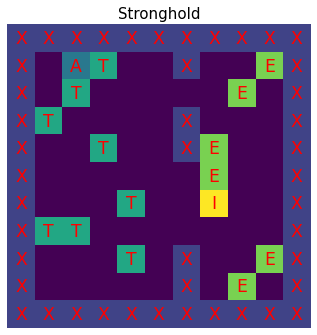

In [2]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

In [91]:
# A class to represent policies the agent can take and evaluation of those policies 
class Agent():
    def __init__(self, env, epsilon, lr, episodes, learning_len = 100, discount_factor = 0.999, mode='Train', view=False):
        self.env = env
        self.epsilon = epsilon
        self.lr = lr
        self.episodes = episodes
        self.learning_len = learning_len
        self.discount_factor = discount_factor
        self.mode = mode
        self.action_space = self.env.getActionSpace()
        self.state_space = self.env.getStateSpace()
        print('The number of actions possible are,', self.action_space)
        print('The number of states in the environment are,', self.state_space)
        self.q_table = np.zeros((self.state_space, self.action_space))          # initialising state-action values in q-table to 0 
        self.step_max = 1000
        self.view = view

    def greedy_policy(self, current_state):
        return np.argmax(self.q_table[current_state,:])

    def Qlearn(self):
        total_rewards = []                                      # holds the total rewards for the evaluation of the q-learning
        eps_decay = [self.epsilon]
        for batch in range(self.episodes//self.learning_len):   # learning occurs for learning_len number of episodes every 
            for learn in range(self.learning_len):
                current_state = self.env.reset()
                for steps in range(self.step_max):
                    if self.mode == 'Train':
                        if np.random.uniform(0, 1) >= self.epsilon:         #  random choice between exploration (random action) or exploitation (ε-greedy policy)
                            choice_action = self.greedy_policy(current_state)
                        else: choice_action = np.random.randint(0, self.action_space - 1)
                    else:
                        choice_action = self.greedy_policy(current_state)
                    state, reward, done, info = self.env.step(choice_action)
                        # update q_table during training according to the equation
                    if self.mode == 'Train':
                        self.q_table[current_state, choice_action] = self.q_table[current_state, choice_action] + self.lr * \
                            (reward + self.discount_factor * self.q_table[state, self.greedy_policy(state)] - self.q_table[current_state, choice_action])   
                        current_state = state
                    if done == True:
                        break 
                self.epsilon *= 0.99                                         # ε decay to encourage mainly exploitation at some point
            avg_reward = self.evaluate_policy(self.greedy_policy, self.episodes, self.view) # run evaluation using ε greedy policy according to q_table
            total_rewards.append(avg_reward)
            eps_decay.append(self.epsilon)
        return total_rewards, self.q_table, eps_decay 

    def evaluate_policy(self, policy, episodes, view = False):  # evaluates the ε greedy policy after exploration/exploitation/training
        total_evaluation_reward = 0
        for i in range(episodes):
            self.env.reset()
            steps = 0 
            done = False
            state, reward, done, info = self.env.step(policy(self.env.agent_state))
            total_evaluation_reward += (self.discount_factor ** steps) * reward
            steps += 1
            while not done:
                state, reward, done, info = self.env.step(policy(state))
                total_evaluation_reward += (self.discount_factor ** steps) * reward
                steps += 1
                if view == True:
                    print("state", state)
                    self.env.render()
                    time.sleep(0.5)
                    clear_output(wait=True)
        return total_evaluation_reward/episodes

    def save_model(self, filename):
        parameters = {'Q-table': self.q_table, 'Epsilon': self.epsilon, 'Gamma': self.discount_factor,\
            'Learning Rate': self.lr}
        pickle.dump(filename, open(filename+ '.trained', 'wb'), -1)
    
    def load_model(self, filename):
        model = pickle.load(filename, open(filename+'.trained', 'rb'), -1)
        self.q_table, self.epsilon, self.discount_factor, self.lr = model[0], model[1], model[2], model[3]

    def plot_evaluation(self, avg_rewards, learning_len, epsilon, lr, discount_factor):
        episodes = []
        for i in range(len(avg_rewards)):
            episodes.append(i * learning_len + 1)

        fig, ax = plt.subplots(figsize=(10,7)); 
        plt.plot(episodes, avg_rewards)
        plt.title('Stronghold Q-learning Avg. Rewards vs. Episodes')
        plt.xlabel("Episodes")
        plt.ylabel("Avg. Reward per {} Episodes".format(learning_len))
        plt.ylim([np.min(avg_rewards)-50, np.max(avg_rewards)+50])
        plt.legend(['Eps={}, Lr={}, Gamma={}'.format(epsilon, lr, discount_factor)], loc='lower right')
        plt.show();

    def plot_policy(self, q_table):
        best_value = np.max(q_table, axis = 1)[:-1].reshape((self.env.size, self.env.size))
        best_action = np.argmax(q_table, axis = 1)[:-1].reshape((self.env.size, self.env.size))
        
        print("Best Policy")
        fig, ax = plt.subplots(figsize=(10,7))
        im = ax.imshow(best_value, cmap ='Set3')

        for i in range(best_value.shape[0]):
            for j in range(best_value.shape[1]):
                if self.env.land[i, j] == 1 or self.env.land[i, j] == 3 or self.env.land[i, j] == 5:
                    sign = self.env.dict_map_display[self.env.land[i,j]]
                elif best_action[i, j] == 0:
                    sign = '^'
                elif best_action[i, j] == 1:
                    sign = 'v'
                elif best_action[i, j] == 2:
                    sign = '<'
                elif best_action[i, j] == 3:
                    sign = '>'
                if i == self.env.starting_pos[0] and j == self.env.starting_pos[1]:
                    sign = 'S '
                text = ax.text(j, i, sign, ha = "center", va = "center", color = "black", fontsize='x-large')
                
        cbar = ax.figure.colorbar(im, ax = ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show(); 

    def print_q_table(self, q_table):
        print("Some Q-table values")
        df = pd.DataFrame(q_table)
        df.columns = ['1', '2', '3', '4']
        print(df[(df > 0).any(1)])

In [100]:
episodes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

## Plotting Epsilon Decay Example

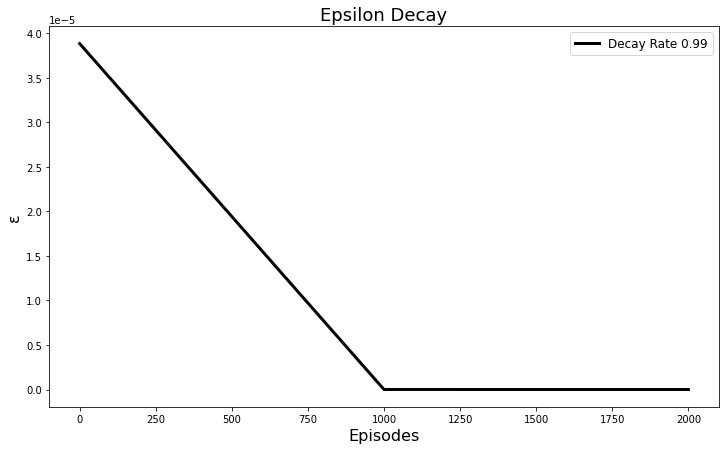

In [103]:
episodes_epsilon_decay = np.arange(0, 3000, 1000)
plt.figure(figsize=(12, 7))
plt.plot(episodes_epsilon_decay, eps_decay[:3], 'k', linewidth=3.0, label='Decay Rate 0.99')
plt.title('Epsilon Decay', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('ε', fontsize=16)
plt.legend(fontsize=12, loc='best')
#plt.savefig('results/eps_decay/Epsilon_decay')
plt.show()

## Investigating Gamma Variation with Constant Learning Rate and Epsilon

## Investigating Epsilon Variation with Constant Learning Rate and Gamma

In [3]:
stronghold.reset()
## Q-learning parameters
epsilon = 1         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e1lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122


ValueError: too many values to unpack (expected 2)

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.7         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e07lr01d999e10kl1k = avg_eval_rewards

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.5         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e05lr01d999e10kl1k = avg_eval_rewards

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.25         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e025lr01d999e10kl1k = avg_eval_rewards

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.1         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e01lr01d999e10kl1k = avg_eval_rewards

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.0         # epsilon changed, rest stay the same
lr = 0.01               
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e00lr01d999e10kl1k = avg_eval_rewards

In [ ]:
pickle.dump(avg_eval_rewards_e1lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e1lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
pickle.dump(avg_eval_rewards_e07lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e07lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
pickle.dump(avg_eval_rewards_e05lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e05lr01d999e10kl1k'+'.q-learn', 'wb'), -1)         # saving the results for epsilon changes
pickle.dump(avg_eval_rewards_e025lr01d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e025lr01d999e10kl1k'+'.q-learn', 'wb'), -1) 
pickle.dump(avg_eval_rewards_e01r015d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e01r015d999e10kl1k'+'.q-learn', 'wb'), -1) 
pickle.dump(avg_eval_rewards_e00r015d999e10kl1k, open('results/eps_diff/avg_eval_rewards_e00r015d999e10kl1k'+'.q-learn', 'wb'), -1) 

## Investigating Learning Rate Variation with Constant Epsilon and Gamma

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  198.44862914085388


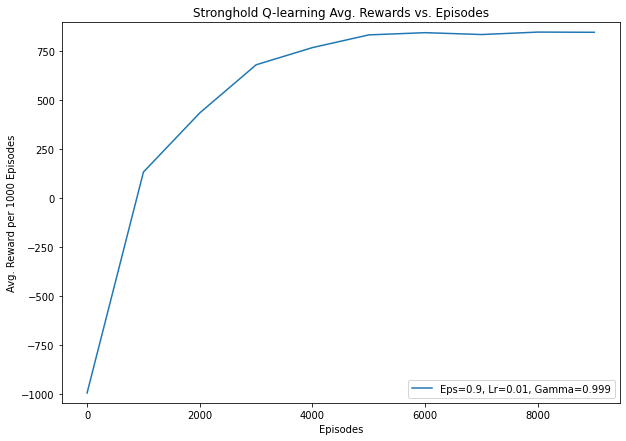

Best Policy


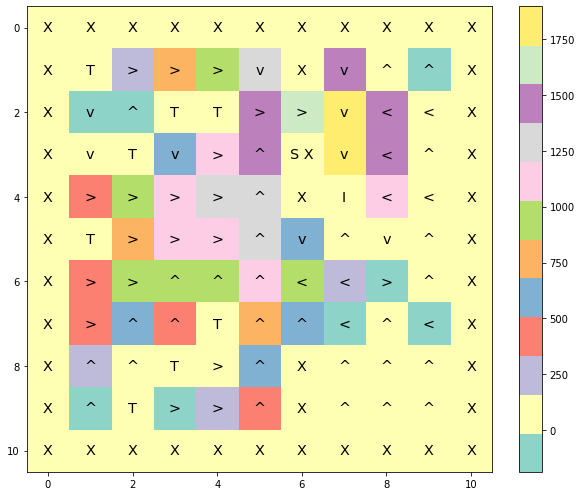

In [60]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
# ε is assigned a real number between 0 and 1.
# With probability ε the agent chooses a random action.
# With probability 1-ε the agent acts greedily.
lr = 0.01               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr01d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  289.22807693481445


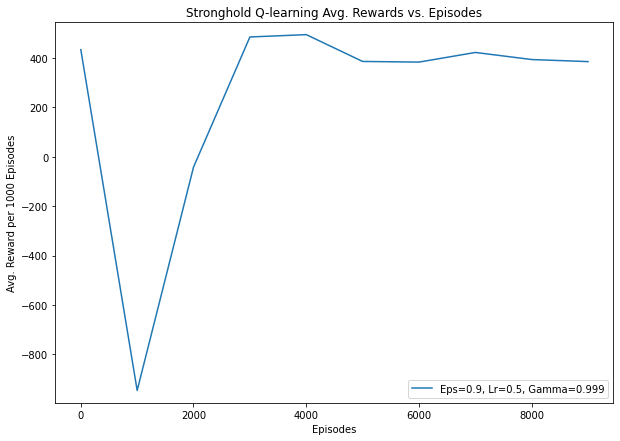

Best Policy


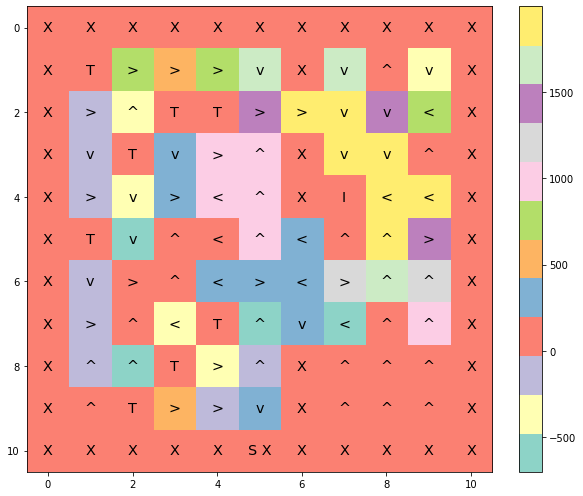

Some Q-table values
               1            2            3            4
13   -956.195974  -962.268399  -937.562500   656.192865
14   -939.990444  -937.531250  -920.182906   451.243063
15   -826.544601  -840.405660  -812.247977   669.111148
16   -480.699190  1651.345555  -504.145423  -541.145485
18   -786.454622  1622.534461  -805.528666  -750.374813
27   -763.070775  -841.895916  -750.000000  1496.819969
28     -6.366132    -6.320061    -6.600050  1923.214260
29     -2.371764  1972.872395    -2.781912    -2.509833
30   -500.250000  1411.973882  -575.695138  -579.809209
31   -664.081113  -750.000000   813.192837  -823.640785
36   -984.375000   294.458889  -976.608347  -980.729063
37   -930.788498  -909.750947  -871.744777  1094.292687
38   1065.882457  -569.809181  -549.828656  -555.622207
40     -0.749750  1994.805777     0.000000     0.000000
41   -463.407489  1951.802516  -437.227927  -500.000000
47   -720.609787  -726.262659  -724.586760   295.282217
48   -677.848449  -621.94477

In [36]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.5               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr5d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  201.1975040435791


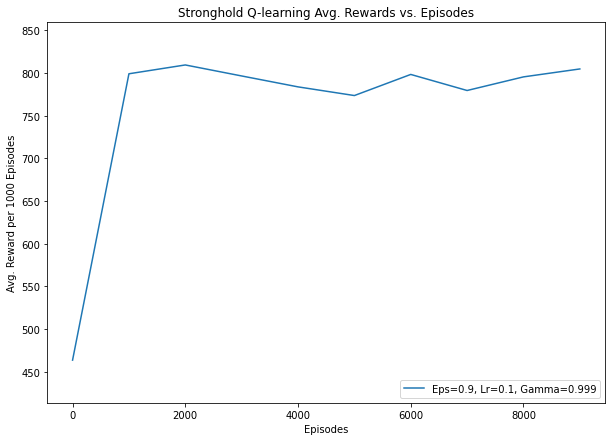

Best Policy


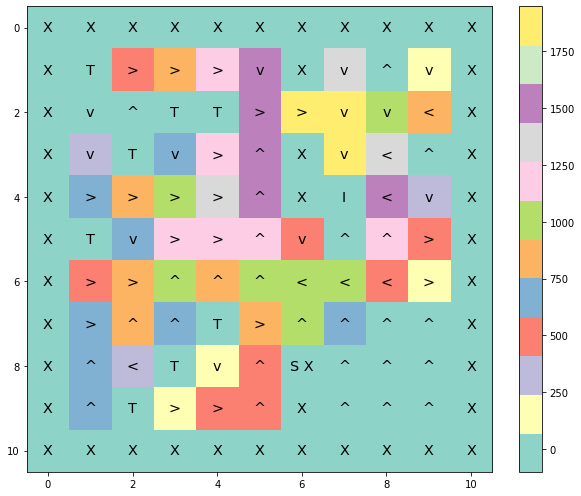

Some Q-table values
               1            2            3            4
13   -470.415012  -486.343792  -463.316793   576.284390
14   -422.742118  -413.424045  -438.944022   876.827170
15   -418.794382  -403.136883  -382.926322  1153.047339
16   -210.829114  1449.058764  -208.496129  -209.667456
18     -0.200000  1376.555976  -100.000000  -100.000000
20   -101.799190    74.292035  -190.000000  -101.259622
23   -651.321560    43.124061  -655.861525  -650.285193
27   -347.500867  -344.213078  -354.668415  1592.559990
28    -16.857541   -27.484823   -14.156583  1791.028890
29     -0.324941  1856.377543    -0.314402    -0.280990
30   -100.090000  1034.248915    -0.113982    -0.118981
31     -0.100000    -0.200000   793.917201     0.000000
34   -589.450829   335.162553  -597.138403  -607.054170
36   -572.645922   644.288998  -561.080379  -561.091917
37   -485.489023  -483.674258  -511.156646  1098.708561
38   1503.767044  -275.594023  -285.553395  -270.596951
40     -0.200000  1948.02609

In [34]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
lr = 0.1               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr1d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  243.7899820804596


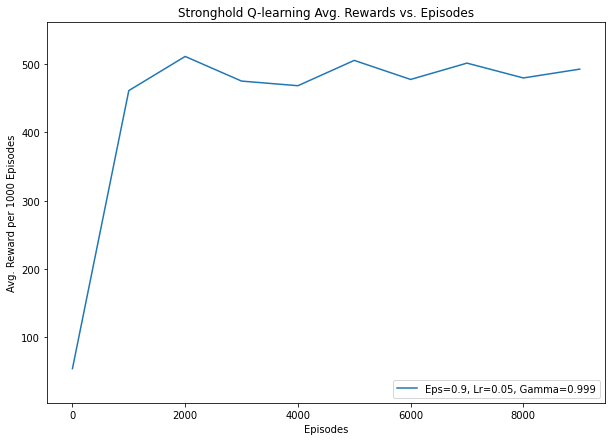

Best Policy


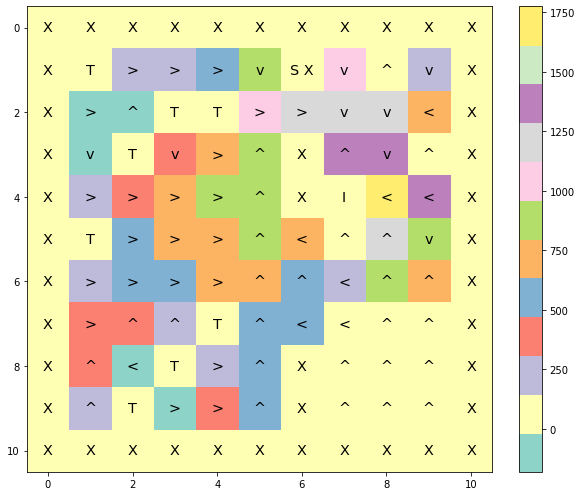

Some Q-table values
               1            2            3            4
13   -428.545186  -434.536915  -432.718221   150.910511
14   -355.894616  -352.240543  -362.450904   280.867171
15   -237.946096  -261.367223  -230.014081   562.414459
16    -75.757547   914.060465   -76.067207   -73.652518
18   -100.476401  1034.615150   -98.145903   -97.680495
20    -50.664900   272.147753   -50.000000   -51.358580
27   -152.707366  -177.792706  -179.786731  1096.432047
28     -5.410578    -7.768639    -7.602714  1257.692098
29     -0.403185  1281.053753    -0.050000    -0.050000
30    -50.000000  1161.554314    -0.985090   -11.364225
31    -87.609623   -97.253404   693.563337   -97.963524
36   -360.378287   318.260997  -358.522976  -353.082357
37   -257.558012  -228.855178  -250.017422   721.568966
38    951.556416   -96.050401   -95.095390   -96.923775
40   1393.230592     0.000000     0.000000     0.000000
41    -27.680759  1347.149669   -45.530277   -50.000000
45   -330.363244  -331.29807

In [33]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
# ε is assigned a real number between 0 and 1.
# With probability ε the agent chooses a random action.
# With probability 1-ε the agent acts greedily.
lr = 0.05               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr05d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  242.66899728775024


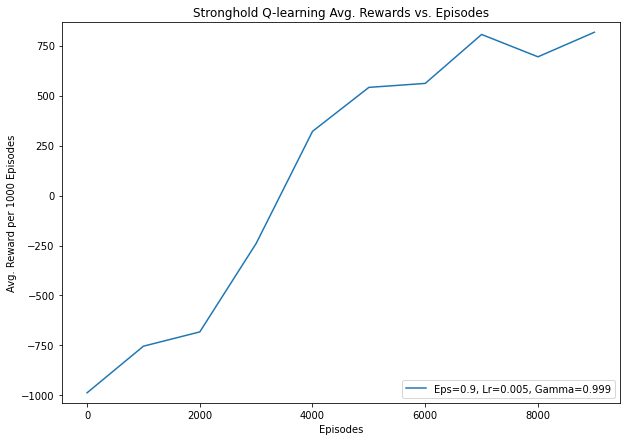

Best Policy


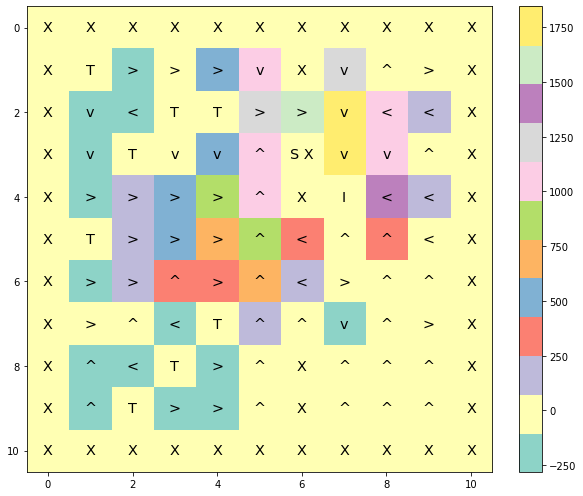

Some Q-table values
              1            2            3            4
14  -149.565999  -152.484211  -149.486371    40.562732
15  -112.374094  -112.838871  -114.993609   531.668583
16   -29.227837  1053.486062   -29.073973   -29.082630
18   -22.100925  1201.678066   -24.972863   -21.526786
27   -70.000596   -69.755039   -72.209620  1191.826104
28    -0.422791    -0.546997    -0.490573  1584.384020
29    -0.045078  1674.322814    -0.041288    -0.049507
30   -14.653021   -16.702145   967.335010   -14.240047
31    -9.993649    -9.975000    89.853019    -9.659642
36  -210.549758     6.431107  -210.850070  -208.978234
37  -139.556589   486.240373  -136.833546  -136.507721
38  1044.637330   -37.344009   -37.285575   -37.130279
40    -0.010052  1845.123158    -0.005025    -0.005025
41    -8.060927   991.778207    -5.009950    -5.004975
46  -159.956038  -160.285358  -158.137154   115.223817
47   -59.811693   -59.520793   -59.587553   561.300742
48   -43.146029   -43.113619   -43.243844   8

In [31]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
# ε is assigned a real number between 0 and 1.
# With probability ε the agent chooses a random action.
# With probability 1-ε the agent acts greedily.
lr = 0.005           #0.001 is too low
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)
avg_eval_rewards_e09lr005d999e10kl1k = avg_eval_rewards

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  133.3985641002655


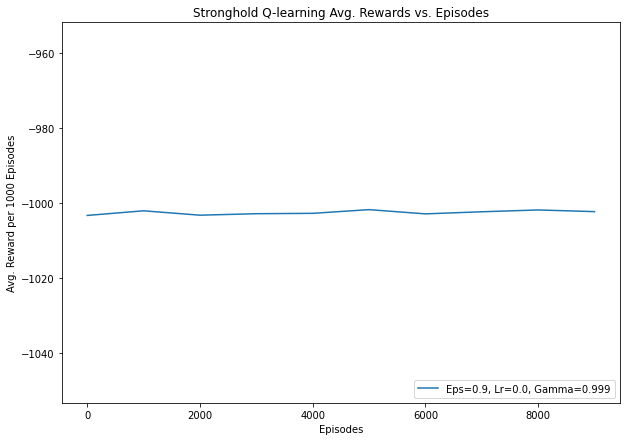

Best Policy


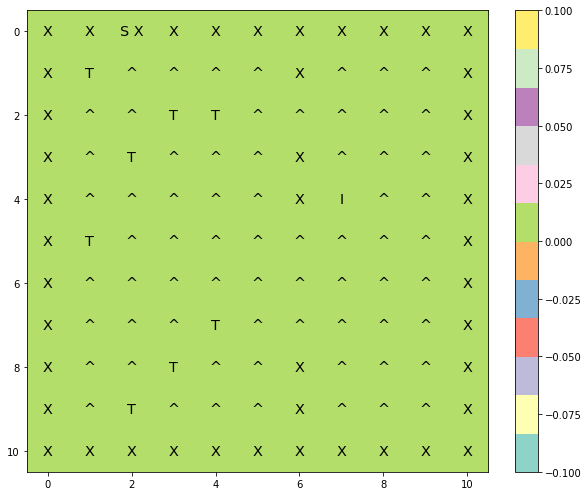

In [48]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       
# ε is assigned a real number between 0 and 1.
# With probability ε the agent chooses a random action.
# With probability 1-ε the agent acts greedily.
lr = 0.0               # learning rate changed, rest stay the same
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
mode = 'Train'
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, mode=mode, view=view)
start = time.time()
avg_eval_rewards, q_table, eps_decay = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
#trained_model = agent.save_model('q-learn')
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    #agent.print_q_table(q_table)
avg_eval_rewards_e09lr0d999e10kl1k = avg_eval_rewards

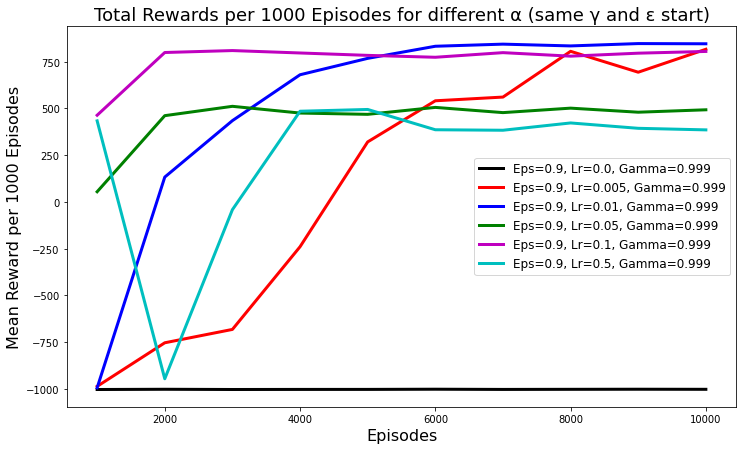

In [102]:
plt.figure(figsize=(12, 7))
plt.plot(episodes, avg_eval_rewards_e09lr0d999e10kl1k, 'k', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.0, 0.999))
plt.plot(episodes, avg_eval_rewards_e09lr005d999e10kl1k, 'r', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.005, 0.999))
plt.plot(episodes, avg_eval_rewards_e09lr01d999e10kl1k, 'b', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.01, 0.999))
plt.plot(episodes, avg_eval_rewards_e09lr05d999e10kl1k, 'g', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.05, 0.999))
plt.plot(episodes, avg_eval_rewards_e09lr1d999e10kl1k, 'm', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.1, 0.999))
plt.plot(episodes, avg_eval_rewards_e09lr5d999e10kl1k, 'c', linewidth=3.0, label='Eps={}, Lr={}, Gamma={}'.format(0.9, 0.5, 0.999))
plt.title('Total Rewards per 1000 Episodes for different α (same γ and ε start)', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean Reward per 1000 Episodes', fontsize=16)
plt.legend(fontsize=12, loc='best')
#plt.savefig('results/lr_diff/Different_learning_rates')
plt.show()

In [ ]:
# pickle.dump(avg_eval_rewards_e09lr0d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr0d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr005d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr005d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr01d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr01d999e10kl1k'+'.q-learn', 'wb'), -1)
# pickle.dump(avg_eval_rewards_e09lr05d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr05d999e10kl1k'+'.q-learn', 'wb'), -1)         # saving the results for learning rate changes
# pickle.dump(avg_eval_rewards_e09lr1d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr1d999e10kl1k'+'.q-learn', 'wb'), -1) 
# pickle.dump(avg_eval_rewards_e09lr5d999e10kl1k, open('results/lr_diff/avg_eval_rewards_e09lr5d999e10kl1k'+'.q-learn', 'wb'), -1) 